In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math
from typing import Tuple

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path
pred_threshold       = params.pred_threshold_tick
regular_start        = params.regular_start
regular_start_pred   = params.regular_start_pred
regular_start_shifted= params.regular_start_shifted
regular_end          = params.regular_end
look_back            = params.look_back_tick
trailing_stop_thresh = params.trailing_stop_thresh_tick

n_trials = 150
n_jobs = 1

In [3]:
df = pd.read_csv(params.final_csv, index_col=0, parse_dates=True)
df

,open,high,low,close,atr_14,vwap_dev,ma_20,macd_12_26,obv,hour,month,bid,ask,signal_smooth
2014-04-03 08:49:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,28.650000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.219822
2014-04-03 08:50:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,28.650000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.220376
2014-04-03 08:51:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,28.650000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.220931
2014-04-03 08:52:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,28.650000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.221487
2014-04-03 08:53:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,28.650000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.222044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,0.304529,1.257638e+00,174.838390,-0.422065,4.758230e+08,20,6,173.512900,173.617100,0.002995
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,0.317029,1.255215e+00,174.736890,-0.466939,4.751988e+08,20,6,173.328000,173.432000,0.002906
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,0.323814,1.254293e+00,174.634390,-0.502359,4.747443e+08,20,6,173.258000,173.362000,0.005611
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,0.322743,1.253874e+00,174.527890,-0.526778,4.736496e+08,20,6,173.228000,173.332000,0.006685


{'ATT_DROPOUT': 0.3,
 'ATT_HEADS': 8,
 'CLIPNORM': 1,
 'DROPOUT_LONG': 0.35,
 'DROPOUT_SHORT': 0.25,
 'EARLY_STOP_PATIENCE': 10,
 'ETA_MIN': 2e-05,
 'INITIAL_LR': 0.0007,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 1,
 'MAX_EPOCHS': 60,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 64,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 60,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.0001}


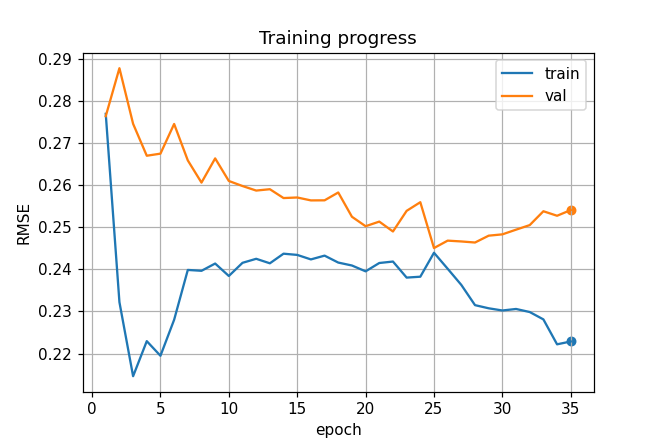

DualMemoryLSTM(
  (short_lstm): LSTM(11, 64, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (do_short): Dropout(p=0.22954890576005055, inplace=False)
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(64, 128, batch_first=True)
  (do_long): Dropout(p=0.343468190413778, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(params.model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

model_best


In [5]:
print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=params.features_cols,
    label_col=params.label_col,
    regular_start=regular_start_pred 
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back    = look_back,
    regular_start=regular_start_pred, 
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH']
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1132845, val=236394, te=240962
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.51801
Test zero‐forecast baseline RMSE = 0.55302


std val: 0.32973263
std test: 0.34039408


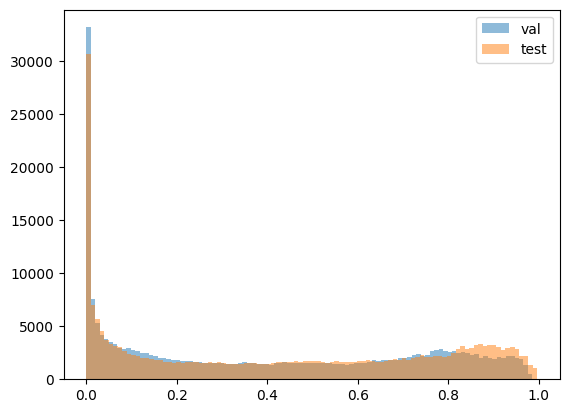

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str
) -> Tuple[float, np.ndarray]:
    """
    Fast per-day RMSE + preds, exactly matching  val‐phase logic:

    • Expects each batch from `loader` to be a tuple of at least
      (xb_batch, yb_batch, day_id_batch, …). We only use the first 3.
    • xb_batch: Tensor(B, W, look_back, F)
    • yb_batch: Tensor(B, W)
    • day_id_batch: Tensor(B,) or (B, W) weekday/day‐id
    """

    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_day_id   = None
    total_sq_err  = 0.0
    total_windows = 0
    all_preds     = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # grab only the first three outputs, ignore raw_close/raw_bid/etc.
            xb_batch, yb_batch, day_id_batch = batch[:3]

            # move to device once
            xb_batch     = xb_batch.to(device, non_blocking=True)
            yb_batch     = yb_batch.to(device, non_blocking=True)
            day_id_batch = day_id_batch.to(device, non_blocking=True)

            # if we got one day_id per window, reduce to one/day
            if day_id_batch.dim() > 1:
                day_id_batch = day_id_batch[:, 0]

            B, W = xb_batch.shape[0], xb_batch.shape[1]

            for i in range(B):
                x_day  = xb_batch[i]             # (W, look_back, F)
                y_day  = yb_batch[i].view(-1)    # (W,)
                day_id = int(day_id_batch[i].item())

                # reset LSTM states exactly as in val loop
                model.reset_short()
                if prev_day_id is not None and day_id < prev_day_id:
                    model.reset_long()
                prev_day_id = day_id

                out      = model(x_day)          # (W, look_back, 1)
                pred_day = out[:, -1, 0]         # (W,)

                total_sq_err  += (pred_day - y_day).pow(2).sum().item()
                total_windows += y_day.numel()
                all_preds.append(pred_day.cpu().numpy())

    rmse  = math.sqrt(total_sq_err / total_windows)
    preds = np.concatenate(all_preds, axis=0)

    print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")
    return rmse, preds


In [9]:
train_rmse, train_preds = evaluate_model(
    model_best, train_loader, device,
    split_name="Train"
)
val_rmse, val_preds     = evaluate_model(
    model_best, val_loader,   device,
    split_name="Validation"
)
test_rmse, test_preds   = evaluate_model(
    model_best, test_loader,  device,
    split_name="Test"
)

print("Train preds:", len(train_preds))
print("Val   preds:", len(val_preds))
print("Test  preds:", len(test_preds))

Train:   0%|          | 0/62 [00:00<?, ?batch/s]


Train RMSE over 1132864 windows = 0.26954


Validation:   0%|          | 0/414 [00:00<?, ?batch/s]


Validation RMSE over 236394 windows = 0.25409


Test:   0%|          | 0/422 [00:00<?, ?batch/s]


Test RMSE over 240962 windows = 0.28541
Train preds: 1132864
Val   preds: 236394
Test  preds: 240962


In [10]:
def add_pred_and_split(
    df: pd.DataFrame,
    train_preds: np.ndarray,
    val_preds: np.ndarray,
    test_preds: np.ndarray,
    day_id_tr: np.ndarray,
    day_id_val: np.ndarray,
    day_id_te: np.ndarray
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Stamp pred_signal for every bar from regular_start_pred onward,
    then simulate actions from regular_start
    """
    # 1) Prepare the output DataFrame
    df_out = df.copy()
    df_out["pred_signal"] = np.nan
    df_out["pred_action"] = 0

    # 2) Map day-id arrays → calendar dates
    all_days = sorted(df_out.index.normalize().unique())
    tr_days  = [all_days[i] for i in np.unique(day_id_tr).astype(int)]
    val_days = [all_days[i] for i in np.unique(day_id_val).astype(int)]
    te_days  = [all_days[i] for i in np.unique(day_id_te).astype(int)]

    # 3) Generic function to stamp preds on each split
    def stamp_split(days, preds, name):
        mask = (
            df_out.index.normalize().isin(days)
            & (df_out.index.time >= regular_start_pred)
        )
        idx = df_out.loc[mask].index
        if len(idx) != len(preds):
            raise ValueError(
                f"{name}: expected {len(idx)} slots, got {len(preds)} preds"
            )
        df_out.loc[idx, "pred_signal"] = preds

    # 4) Stamp Train, Val, Test
    stamp_split(tr_days, train_preds, name="Train")
    stamp_split(val_days, val_preds,   name="Val")
    stamp_split(te_days,  test_preds,  name="Test")

    train_val_days = set(tr_days + val_days)
    df_train_val  = df_out[df_out.index.normalize().isin(train_val_days)].copy()
    df_test       = df_out[df_out.index.normalize().isin(te_days)].copy()

    return df_train_val, train_val_days, df_test, te_days


In [11]:
df_train_val, train_val_days, df_test, te_days = add_pred_and_split(
                                                                    df=df, 
                                                                    train_preds=train_preds,
                                                                    val_preds=val_preds,
                                                                    test_preds=test_preds, 
                                                                    day_id_tr=day_id_tr,
                                                                    day_id_val=day_id_val,
                                                                    day_id_te=day_id_te
                                                                    )

df_train_val

,open,high,low,close,atr_14,vwap_dev,ma_20,macd_12_26,obv,hour,month,bid,ask,signal_smooth,pred_signal,pred_action
2014-04-03 08:49:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,28.65000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.219822,NaN,0
2014-04-03 08:50:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,28.65000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.220376,NaN,0
2014-04-03 08:51:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,28.65000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.220931,NaN,0
2014-04-03 08:52:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,28.65000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.221487,NaN,0
2014-04-03 08:53:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,28.65000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.222044,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-11 20:56:00,140.510,140.62,140.505,140.610,0.105893,1.166374e+00,140.52549,0.040273,4.742212e+08,20,10,140.567800,140.652200,0.000000,0.264903,0
2023-10-11 20:57:00,140.610,140.66,140.530,140.550,0.112493,1.165446e+00,140.53499,0.038238,4.740805e+08,20,10,140.507800,140.592200,0.000000,0.264527,0
2023-10-11 20:58:00,140.550,140.60,140.530,140.585,0.111071,1.165982e+00,140.54474,0.039000,4.742260e+08,20,10,140.542800,140.627200,0.000000,0.264571,0
2023-10-11 20:59:00,140.580,140.62,140.520,140.565,0.112571,1.165662e+00,140.54949,0.037557,4.738080e+08,20,10,140.522800,140.607200,0.000000,0.264390,0


In [12]:
# # === One‐time setup: extract raw arrays + map each day to integer positions ===
# signals     = df_train_val["pred_signal"].values.astype(float)
# closes      = df_train_val["close"].values.astype(float)
# bids        = df_train_val["bid"].values.astype(float)
# asks        = df_train_val["ask"].values.astype(float)
# timestamps  = df_train_val.index.values.astype("datetime64[ns]")

# day_positions = {
#     day: np.flatnonzero(df_train_val.index.normalize().values == day)
#     for day in train_val_days
# }


# # === Wrapper for generate_trade_actions that includes both “close” and “pred_signal” ===
# def generate_trade_actions_np(
#     signal_array: np.ndarray,
#     close_array:  np.ndarray,
#     buy_threshold: float,
#     trailing_stop: float,
#     timestamps:    np.ndarray,
#     regular_start,
# ):
#     df_day = pd.DataFrame(
#         {
#             "pred_signal": signal_array,
#             "close"      : close_array
#         },
#         index=pd.DatetimeIndex(timestamps)
#     )
#     actions = trades.generate_trade_actions(
#         df=df_day,
#         col_signal="pred_signal",
#         col_action="pred_action",
#         buy_threshold=buy_threshold,
#         trailing_stop_thresh=trailing_stop,
#         regular_start=regular_start
#     )["pred_action"] \
#       .fillna(0) \
#       .astype(np.int8) \
#       .values

#     return actions


# # === Wrapper for simulate_trading that includes “bid”, “ask” and the action array ===
# def simulate_trading_np(
#     timestamps,
#     actions,
#     regular_start,
#     regular_end,
#     ticker
# ):
#     df_sim = pd.DataFrame(
#         {
#             "bid"        : bids,
#             "ask"        : asks,
#             "pred_action": actions
#         },
#         index=pd.DatetimeIndex(timestamps)
#     )

#     return trades.simulate_trading(
#         results_by_day_sign=df_sim,
#         col_action="pred_action",
#         regular_start=regular_start,
#         regular_end=regular_end,
#         ticker=ticker
#     )


# # === Optuna objective: pure NumPy + minimal pandas per‐trial ===
# def objective(trial):
#     print("------------------------------------------------")
#     print("1) Suggest hyperparameters")
#     pred_threshold     = trial.suggest_float("pred_threshold",      0.03, 0.66)
#     trailing_stop_pred = trial.suggest_float("trailing_stop_pred", 0.01, 0.50)

#     print("2) Generate actions per day")
#     n = signals.shape[0]
#     actions_arr = np.zeros(n, dtype=np.int8)

#     for idxs in day_positions.values():
#         day_sig   = signals[idxs]
#         day_close = closes[idxs]
#         day_time  = timestamps[idxs]

#         day_act = generate_trade_actions_np(
#             signal_array   = day_sig,
#             close_array    = day_close,
#             buy_threshold  = pred_threshold,
#             trailing_stop  = trailing_stop_pred,
#             timestamps     = day_time,
#             regular_start  = params.regular_start
#         )
#         actions_arr[idxs] = day_act

#     print("3) Simulate and compute average daily P&L")
#     sim_results = simulate_trading_np(
#         timestamps    = timestamps,
#         actions       = actions_arr,
#         regular_start = params.regular_start,
#         regular_end   = params.regular_end,
#         ticker        = params.ticker
#     )

#     daily_returns = [
#         stats["Strategy Return ($)"]
#         for _, (_, _, stats) in sim_results.items()
#     ]
#     total_pnl     = float(np.sum(daily_returns))
#     num_days      = len(train_val_days)
#     avg_daily_pnl = total_pnl / num_days

#     print(f"→ Total P&L across {num_days} days: ${total_pnl:.2f}")
#     print(f"→ Average daily P&L         : ${avg_daily_pnl:.4f}\n")

#     return avg_daily_pnl


In [13]:
# # === Study setup & execution ===
# pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)
# storage = RDBStorage(
#     url="sqlite:///optuna_study.db",
#     engine_kwargs={"connect_args": {"timeout": 20, "check_same_thread": False}}
# )
# study = optuna.create_study(
#     storage        = storage,
#     load_if_exists = True,
#     direction      = "maximize",
#     pruner         = pruner,
# )
# study.optimize(
#     objective,
#     n_trials          = n_trials,
#     n_jobs            = n_jobs,
#     callbacks         = [plots.cleanup_callback, plots.lightweight_plot_callback],
#     gc_after_trial    = True,
#     show_progress_bar = False,
#     catch              = (MemoryError,),
# )

# # === Final plots & JSON dump ===
# fig = plot_optimization_history(study)
# fig.set_size_inches(8, 4)
# fig.axes[0].set_title("Optuna Optimization History")
# plt.show()

# print("Best Parameters       :", study.best_params)
# print("Best Average Daily P&L:", study.best_value)

# importances = get_param_importances(study)
# print("\nHyperparameter importances (higher ⇒ more impact):")
# for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
#     print(f"  {name:20s}: {score:.3f}")

# first_day  = df_train_val.index.normalize().min().strftime("%Y%m%d")
# last_day   = df_train_val.index.normalize().max().strftime("%Y%m%d")
# file_name  = f"{params.ticker}_{first_day}-{last_day}_optuna_predsig_pars.json"
# file_path  = os.path.join(params.optuna_folder, file_name)

# with open(file_path, "w") as f:
#     json.dump({
#         "best_params": study.best_params,
#         "best_value" : study.best_value,
#         "importances": importances,
#         "trials": [
#             {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
#             for t in study.trials
#         ],
#     }, f, indent=4)

# print(f"\nOptuna results (and importances) saved to: {file_path}")


In [14]:
# raw NumPy arrays
signals    = df_train_val["pred_signal"].values.astype(float)
closes     = df_train_val["close"].values.astype(float)
bids       = df_train_val["bid"].values.astype(float)
asks       = df_train_val["ask"].values.astype(float)
timestamps = df_train_val.index.values.astype("datetime64[ns]")

# map each day → positions
day_positions = {
    day: np.flatnonzero(df_train_val.index.normalize().values == day)
    for day in train_val_days
}

# master DataFrame with empty action col
df_master = pd.DataFrame({
    "pred_signal": signals,
    "close"      : closes,
    "bid"        : bids,
    "ask"        : asks,
}, index=pd.DatetimeIndex(timestamps))
df_master["pred_action"] = 0


In [15]:
def objective(trial):
    # —————— 1) Clean slate for this trial ——————
    # Reset every single pred_action back to 0 in-place
    df_master["pred_action"].values[:] = 0

    # —————— 2) Hyper-parameter suggestions ——————
    pred_threshold     = trial.suggest_float("pred_threshold",     0.03, 0.66)
    trailing_stop_pred = trial.suggest_float("trailing_stop_pred", 0.01, 0.5)

    # —————— 3) Generate actions per day ——————
    print('-----------------------------------')
    print("Generate actions per day...")
    for idxs in day_positions.values():
        day_df = pd.DataFrame({
            "pred_signal": signals[idxs],
            "close"      : closes[idxs]
        }, index=pd.DatetimeIndex(timestamps[idxs]))

        day_act = trades.generate_trade_actions(
            df=day_df,
            col_signal="pred_signal",
            col_action="pred_action",
            buy_threshold=pred_threshold,
            trailing_stop_thresh=trailing_stop_pred,
            regular_start=params.regular_start
        )["pred_action"].fillna(0).astype(np.int8).values

        df_master["pred_action"].values[idxs] = day_act

    # —————— 4) Simulate & score ——————
    print("Simulate and compute average daily P&L...")
    sim_results = trades.simulate_trading(
        results_by_day_sign=df_master,
        col_action="pred_action",
        regular_start=params.regular_start,
        regular_end=params.regular_end,
        ticker=params.ticker
    )

    daily_returns = [
        stats["Strategy Return ($)"]
        for _, (_, _, stats) in sim_results.items()
    ]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / len(train_val_days)

    print(f"→ Total P&L: ${total_pnl:.2f}  |  Avg daily P&L: ${avg_daily_pnl:.4f}\n")
    return avg_daily_pnl


[I 2025-08-02 13:42:08,580] A new study created in RDB with name: no-name-95ed1eba-8d7a-408d-9bef-f97b2167a913


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:43:11,679] Trial 0 finished with value: 0.3276772310258549 and parameters: {'pred_threshold': 0.524490382015724, 'trailing_stop_pred': 0.4108130486264724}. Best is trial 0 with value: 0.3276772310258549.


→ Total P&L: $785.77  |  Avg daily P&L: $0.3277



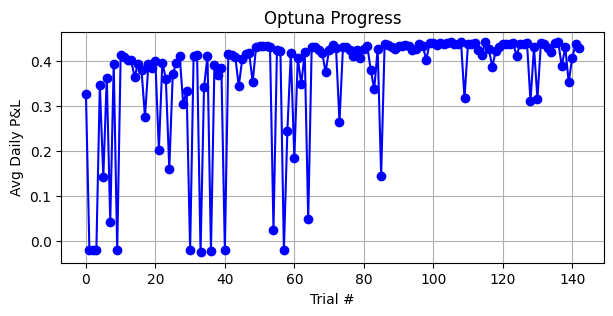

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:44:15,030] Trial 1 finished with value: -0.020481651376146794 and parameters: {'pred_threshold': 0.14404976819366977, 'trailing_stop_pred': 0.07253433874337474}. Best is trial 0 with value: 0.3276772310258549.


→ Total P&L: $-49.12  |  Avg daily P&L: $-0.0205

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:45:18,243] Trial 2 finished with value: -0.020520433694745627 and parameters: {'pred_threshold': 0.13322681242576578, 'trailing_stop_pred': 0.4341286532621568}. Best is trial 0 with value: 0.3276772310258549.


→ Total P&L: $-49.21  |  Avg daily P&L: $-0.0205

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:46:20,797] Trial 3 finished with value: -0.02049708090075063 and parameters: {'pred_threshold': 0.040380374861424026, 'trailing_stop_pred': 0.34940093655149723}. Best is trial 0 with value: 0.3276772310258549.


→ Total P&L: $-49.15  |  Avg daily P&L: $-0.0205

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:47:22,147] Trial 4 finished with value: 0.34614970809007506 and parameters: {'pred_threshold': 0.48106350141326104, 'trailing_stop_pred': 0.12843519826359284}. Best is trial 4 with value: 0.34614970809007506.


→ Total P&L: $830.07  |  Avg daily P&L: $0.3461

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:48:22,798] Trial 5 finished with value: 0.14284320266889072 and parameters: {'pred_threshold': 0.650626905207341, 'trailing_stop_pred': 0.0739741846468039}. Best is trial 4 with value: 0.34614970809007506.


→ Total P&L: $342.54  |  Avg daily P&L: $0.1428

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:49:23,667] Trial 6 finished with value: 0.36348373644703924 and parameters: {'pred_threshold': 0.4585464894333017, 'trailing_stop_pred': 0.15212964266042817}. Best is trial 6 with value: 0.36348373644703924.


→ Total P&L: $871.63  |  Avg daily P&L: $0.3635

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:50:26,767] Trial 7 finished with value: 0.042431609674728935 and parameters: {'pred_threshold': 0.19551851269558526, 'trailing_stop_pred': 0.41043543590101994}. Best is trial 6 with value: 0.36348373644703924.


→ Total P&L: $101.75  |  Avg daily P&L: $0.0424

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:51:28,434] Trial 8 finished with value: 0.39451584653878236 and parameters: {'pred_threshold': 0.26035865941412795, 'trailing_stop_pred': 0.14371031740193752}. Best is trial 8 with value: 0.39451584653878236.


→ Total P&L: $946.05  |  Avg daily P&L: $0.3945

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:52:31,389] Trial 9 finished with value: -0.02051668056713929 and parameters: {'pred_threshold': 0.13065332785662387, 'trailing_stop_pred': 0.2929536714955347}. Best is trial 8 with value: 0.39451584653878236.


→ Total P&L: $-49.20  |  Avg daily P&L: $-0.0205

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:53:32,743] Trial 10 finished with value: 0.4133540450375313 and parameters: {'pred_threshold': 0.31589350392238436, 'trailing_stop_pred': 0.20609641547054747}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $991.22  |  Avg daily P&L: $0.4134

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:54:34,183] Trial 11 finished with value: 0.409521684737281 and parameters: {'pred_threshold': 0.30678027102650557, 'trailing_stop_pred': 0.21756734716398501}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $982.03  |  Avg daily P&L: $0.4095

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:55:35,615] Trial 12 finished with value: 0.4035900750625521 and parameters: {'pred_threshold': 0.34490572982198175, 'trailing_stop_pred': 0.23446824650151182}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $967.81  |  Avg daily P&L: $0.4036

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:56:36,963] Trial 13 finished with value: 0.40270683903252713 and parameters: {'pred_threshold': 0.33535146720642167, 'trailing_stop_pred': 0.22686016860497857}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $965.69  |  Avg daily P&L: $0.4027

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:57:38,459] Trial 14 finished with value: 0.36541951626355296 and parameters: {'pred_threshold': 0.26177628035012157, 'trailing_stop_pred': 0.28283359904724126}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $876.28  |  Avg daily P&L: $0.3654

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:58:39,421] Trial 15 finished with value: 0.3947256046705588 and parameters: {'pred_threshold': 0.4012935029444978, 'trailing_stop_pred': 0.1987960473956186}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $946.55  |  Avg daily P&L: $0.3947

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 13:59:40,960] Trial 16 finished with value: 0.38082026688907417 and parameters: {'pred_threshold': 0.27560681078475197, 'trailing_stop_pred': 0.31591241022593514}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $913.21  |  Avg daily P&L: $0.3808

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:00:41,973] Trial 17 finished with value: 0.2762998331943286 and parameters: {'pred_threshold': 0.5758157053298539, 'trailing_stop_pred': 0.18100758571961506}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $662.57  |  Avg daily P&L: $0.2763

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:01:42,865] Trial 18 finished with value: 0.3948986655546289 and parameters: {'pred_threshold': 0.40710992753425296, 'trailing_stop_pred': 0.05138634088774341}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $946.97  |  Avg daily P&L: $0.3949

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:02:44,216] Trial 19 finished with value: 0.38390617180984155 and parameters: {'pred_threshold': 0.3080874761649615, 'trailing_stop_pred': 0.35024323873899477}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $920.61  |  Avg daily P&L: $0.3839

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:03:45,053] Trial 20 finished with value: 0.399640950792327 and parameters: {'pred_threshold': 0.3970433747765061, 'trailing_stop_pred': 0.11832504588847358}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $958.34  |  Avg daily P&L: $0.3996

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:04:47,011] Trial 21 finished with value: 0.20270517097581317 and parameters: {'pred_threshold': 0.21349295933685852, 'trailing_stop_pred': 0.24094694410884185}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $486.09  |  Avg daily P&L: $0.2027

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:05:48,069] Trial 22 finished with value: 0.3968536280233529 and parameters: {'pred_threshold': 0.36905320243871353, 'trailing_stop_pred': 0.23860671464961092}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $951.66  |  Avg daily P&L: $0.3969

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:06:49,847] Trial 23 finished with value: 0.361232693911593 and parameters: {'pred_threshold': 0.30572444984639946, 'trailing_stop_pred': 0.49549071432110514}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $866.24  |  Avg daily P&L: $0.3612

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:07:52,173] Trial 24 finished with value: 0.1610462885738115 and parameters: {'pred_threshold': 0.2077312756117012, 'trailing_stop_pred': 0.1950649194398802}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $386.19  |  Avg daily P&L: $0.1610

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:08:53,189] Trial 25 finished with value: 0.3712743953294412 and parameters: {'pred_threshold': 0.4450678962392518, 'trailing_stop_pred': 0.27370998815443526}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $890.32  |  Avg daily P&L: $0.3713

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:09:54,390] Trial 26 finished with value: 0.3959495412844037 and parameters: {'pred_threshold': 0.3486921191244498, 'trailing_stop_pred': 0.32806894247150015}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $949.49  |  Avg daily P&L: $0.3959

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:10:55,723] Trial 27 finished with value: 0.410790658882402 and parameters: {'pred_threshold': 0.307995189229398, 'trailing_stop_pred': 0.210420910075666}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $985.08  |  Avg daily P&L: $0.4108

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:11:57,639] Trial 28 finished with value: 0.30525437864887406 and parameters: {'pred_threshold': 0.22559186400455195, 'trailing_stop_pred': 0.1767730593639091}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $732.00  |  Avg daily P&L: $0.3053

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:12:58,307] Trial 29 finished with value: 0.33343994995829856 and parameters: {'pred_threshold': 0.492989324594305, 'trailing_stop_pred': 0.01591280676338072}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $799.59  |  Avg daily P&L: $0.3334

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:14:01,117] Trial 30 finished with value: -0.02049708090075063 and parameters: {'pred_threshold': 0.06619570045556339, 'trailing_stop_pred': 0.09162292767760172}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $-49.15  |  Avg daily P&L: $-0.0205

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:15:02,580] Trial 31 finished with value: 0.41083611342785653 and parameters: {'pred_threshold': 0.3138254067338666, 'trailing_stop_pred': 0.21695711243453553}. Best is trial 10 with value: 0.4133540450375313.


→ Total P&L: $985.18  |  Avg daily P&L: $0.4108

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:16:04,418] Trial 32 finished with value: 0.41358006672226855 and parameters: {'pred_threshold': 0.29955272125263727, 'trailing_stop_pred': 0.20758888313565216}. Best is trial 32 with value: 0.41358006672226855.


→ Total P&L: $991.76  |  Avg daily P&L: $0.4136

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:17:06,777] Trial 33 finished with value: -0.02494495412844037 and parameters: {'pred_threshold': 0.1759097621195246, 'trailing_stop_pred': 0.1659950284017438}. Best is trial 32 with value: 0.41358006672226855.


→ Total P&L: $-59.82  |  Avg daily P&L: $-0.0249

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:18:08,341] Trial 34 finished with value: 0.3422902418682235 and parameters: {'pred_threshold': 0.24779271646278744, 'trailing_stop_pred': 0.27019322459552947}. Best is trial 32 with value: 0.41358006672226855.


→ Total P&L: $820.81  |  Avg daily P&L: $0.3423

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:19:09,624] Trial 35 finished with value: 0.4107718932443703 and parameters: {'pred_threshold': 0.30823994408696975, 'trailing_stop_pred': 0.20284515259819227}. Best is trial 32 with value: 0.41358006672226855.


→ Total P&L: $985.03  |  Avg daily P&L: $0.4108

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:20:11,863] Trial 36 finished with value: -0.022413261050875734 and parameters: {'pred_threshold': 0.1661827259933186, 'trailing_stop_pred': 0.12190955120693917}. Best is trial 32 with value: 0.41358006672226855.


→ Total P&L: $-53.75  |  Avg daily P&L: $-0.0224

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:21:13,225] Trial 37 finished with value: 0.39251542952460383 and parameters: {'pred_threshold': 0.3711132670853519, 'trailing_stop_pred': 0.2513897017102242}. Best is trial 32 with value: 0.41358006672226855.


→ Total P&L: $941.25  |  Avg daily P&L: $0.3925

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:22:14,530] Trial 38 finished with value: 0.36857506255212674 and parameters: {'pred_threshold': 0.28626655026694203, 'trailing_stop_pred': 0.38462384253824783}. Best is trial 32 with value: 0.41358006672226855.


→ Total P&L: $883.84  |  Avg daily P&L: $0.3686

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:23:15,462] Trial 39 finished with value: 0.38406797331109255 and parameters: {'pred_threshold': 0.42556786110813954, 'trailing_stop_pred': 0.14801696291906336}. Best is trial 32 with value: 0.41358006672226855.


→ Total P&L: $920.99  |  Avg daily P&L: $0.3841

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:24:17,668] Trial 40 finished with value: -0.02051668056713929 and parameters: {'pred_threshold': 0.11432925764208357, 'trailing_stop_pred': 0.10106456352470053}. Best is trial 32 with value: 0.41358006672226855.


→ Total P&L: $-49.20  |  Avg daily P&L: $-0.0205

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:25:18,757] Trial 41 finished with value: 0.41515429524603836 and parameters: {'pred_threshold': 0.32590921300407116, 'trailing_stop_pred': 0.2043606002482575}. Best is trial 41 with value: 0.41515429524603836.


→ Total P&L: $995.54  |  Avg daily P&L: $0.4152

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:26:19,687] Trial 42 finished with value: 0.41320892410341953 and parameters: {'pred_threshold': 0.3304270604565284, 'trailing_stop_pred': 0.2058109227666509}. Best is trial 41 with value: 0.41515429524603836.


→ Total P&L: $990.88  |  Avg daily P&L: $0.4132

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:27:20,788] Trial 43 finished with value: 0.41022435362802334 and parameters: {'pred_threshold': 0.36334451131929707, 'trailing_stop_pred': 0.17078428106381155}. Best is trial 41 with value: 0.41515429524603836.


→ Total P&L: $983.72  |  Avg daily P&L: $0.4102

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:28:22,122] Trial 44 finished with value: 0.34432693911593 and parameters: {'pred_threshold': 0.2457854011468668, 'trailing_stop_pred': 0.25775952390050016}. Best is trial 41 with value: 0.41515429524603836.


→ Total P&L: $825.70  |  Avg daily P&L: $0.3443

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:29:23,387] Trial 45 finished with value: 0.40474770642201835 and parameters: {'pred_threshold': 0.33710184432558005, 'trailing_stop_pred': 0.21942998845442632}. Best is trial 41 with value: 0.41515429524603836.


→ Total P&L: $970.59  |  Avg daily P&L: $0.4047

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:30:24,861] Trial 46 finished with value: 0.41724353628023353 and parameters: {'pred_threshold': 0.28078267014609737, 'trailing_stop_pred': 0.1510698199545851}. Best is trial 46 with value: 0.41724353628023353.


→ Total P&L: $1000.55  |  Avg daily P&L: $0.4172

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:31:26,264] Trial 47 finished with value: 0.4185496246872394 and parameters: {'pred_threshold': 0.28108618210455616, 'trailing_stop_pred': 0.1318418541932334}. Best is trial 47 with value: 0.4185496246872394.


→ Total P&L: $1003.68  |  Avg daily P&L: $0.4185

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:32:27,541] Trial 48 finished with value: 0.353163469557965 and parameters: {'pred_threshold': 0.23497870678202298, 'trailing_stop_pred': 0.1391969377499678}. Best is trial 47 with value: 0.4185496246872394.


→ Total P&L: $846.89  |  Avg daily P&L: $0.3532

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:33:28,977] Trial 49 finished with value: 0.4325988323603003 and parameters: {'pred_threshold': 0.28464790219799396, 'trailing_stop_pred': 0.05572351489886594}. Best is trial 49 with value: 0.4325988323603003.


→ Total P&L: $1037.37  |  Avg daily P&L: $0.4326

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:34:30,125] Trial 50 finished with value: 0.43365679733110923 and parameters: {'pred_threshold': 0.27335556052165766, 'trailing_stop_pred': 0.05086827563163547}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1039.91  |  Avg daily P&L: $0.4337

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:35:31,545] Trial 51 finished with value: 0.4332902418682236 and parameters: {'pred_threshold': 0.2748632211374145, 'trailing_stop_pred': 0.05413196264868696}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1039.03  |  Avg daily P&L: $0.4333

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:36:33,058] Trial 52 finished with value: 0.43294412010008343 and parameters: {'pred_threshold': 0.2707157992575425, 'trailing_stop_pred': 0.04730862579313267}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1038.20  |  Avg daily P&L: $0.4329

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:37:36,296] Trial 53 finished with value: 0.431929941618015 and parameters: {'pred_threshold': 0.2716939326078756, 'trailing_stop_pred': 0.053015242052031716}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1035.77  |  Avg daily P&L: $0.4319

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:38:38,686] Trial 54 finished with value: 0.025390742285237692 and parameters: {'pred_threshold': 0.18949179556883394, 'trailing_stop_pred': 0.04635776755549798}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $60.89  |  Avg daily P&L: $0.0254

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:39:39,958] Trial 55 finished with value: 0.424756046705588 and parameters: {'pred_threshold': 0.2647481555116032, 'trailing_stop_pred': 0.026690505071661163}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1018.56  |  Avg daily P&L: $0.4248

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:40:41,229] Trial 56 finished with value: 0.4219345287739783 and parameters: {'pred_threshold': 0.2610444475646779, 'trailing_stop_pred': 0.011402097170902736}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1011.80  |  Avg daily P&L: $0.4219

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:41:43,782] Trial 57 finished with value: -0.020451209341117608 and parameters: {'pred_threshold': 0.1458915440962659, 'trailing_stop_pred': 0.05036445011691884}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $-49.04  |  Avg daily P&L: $-0.0205

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:42:46,220] Trial 58 finished with value: 0.24559633027522937 and parameters: {'pred_threshold': 0.21386279448042178, 'trailing_stop_pred': 0.07164318104914426}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $588.94  |  Avg daily P&L: $0.2456

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:43:49,717] Trial 59 finished with value: 0.4181784820683903 and parameters: {'pred_threshold': 0.2655240282124028, 'trailing_stop_pred': 0.07907493059691459}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1002.79  |  Avg daily P&L: $0.4182

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:44:51,929] Trial 60 finished with value: 0.18421351125938282 and parameters: {'pred_threshold': 0.6245686052850794, 'trailing_stop_pred': 0.03226626466247895}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $441.74  |  Avg daily P&L: $0.1842

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:45:54,563] Trial 61 finished with value: 0.4067768974145121 and parameters: {'pred_threshold': 0.25190504424845567, 'trailing_stop_pred': 0.010899734523867}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $975.45  |  Avg daily P&L: $0.4068

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:46:57,509] Trial 62 finished with value: 0.3491259382819016 and parameters: {'pred_threshold': 0.22902000171837467, 'trailing_stop_pred': 0.0349577924370316}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $837.20  |  Avg daily P&L: $0.3491

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:47:59,558] Trial 63 finished with value: 0.4197944120100083 and parameters: {'pred_threshold': 0.2639984423126925, 'trailing_stop_pred': 0.0722380283813403}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1006.67  |  Avg daily P&L: $0.4198

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:49:03,454] Trial 64 finished with value: 0.04804128440366971 and parameters: {'pred_threshold': 0.19244606816311238, 'trailing_stop_pred': 0.03366119051173749}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $115.20  |  Avg daily P&L: $0.0480

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:50:06,639] Trial 65 finished with value: 0.4322935779816513 and parameters: {'pred_threshold': 0.2828055024058798, 'trailing_stop_pred': 0.059553583102880586}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1036.64  |  Avg daily P&L: $0.4323

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:51:10,400] Trial 66 finished with value: 0.43103794829024195 and parameters: {'pred_threshold': 0.2836207107797536, 'trailing_stop_pred': 0.06350984844382003}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1033.63  |  Avg daily P&L: $0.4310

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:52:12,658] Trial 67 finished with value: 0.4241693077564637 and parameters: {'pred_threshold': 0.29048112865331616, 'trailing_stop_pred': 0.10445149141438718}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1017.16  |  Avg daily P&L: $0.4242

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:53:14,739] Trial 68 finished with value: 0.4194032527105922 and parameters: {'pred_threshold': 0.3636176404389187, 'trailing_stop_pred': 0.06259179719944225}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1005.73  |  Avg daily P&L: $0.4194

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:54:18,608] Trial 69 finished with value: 0.375487906588824 and parameters: {'pred_threshold': 0.23869749364987472, 'trailing_stop_pred': 0.09122676453783883}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $900.42  |  Avg daily P&L: $0.3755

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:55:21,214] Trial 70 finished with value: 0.4247564637197665 and parameters: {'pred_threshold': 0.34919974378663127, 'trailing_stop_pred': 0.06012772635099422}. Best is trial 50 with value: 0.43365679733110923.


→ Total P&L: $1018.57  |  Avg daily P&L: $0.4248

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:56:25,319] Trial 71 finished with value: 0.4360429524603836 and parameters: {'pred_threshold': 0.2883682339894696, 'trailing_stop_pred': 0.05605090779254076}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $1045.63  |  Avg daily P&L: $0.4360

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total P&L: $1031.50  |  Avg daily P&L: $0.4301



[I 2025-08-02 14:57:29,445] Trial 72 finished with value: 0.43014970809007497 and parameters: {'pred_threshold': 0.29637140439883874, 'trailing_stop_pred': 0.08791199283136757}. Best is trial 71 with value: 0.4360429524603836.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:58:36,564] Trial 73 finished with value: 0.26507047539616346 and parameters: {'pred_threshold': 0.21759750073091472, 'trailing_stop_pred': 0.10994532342845498}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $635.64  |  Avg daily P&L: $0.2651

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 14:59:40,239] Trial 74 finished with value: 0.430882402001668 and parameters: {'pred_threshold': 0.3210990235070836, 'trailing_stop_pred': 0.04454976238848101}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $1033.26  |  Avg daily P&L: $0.4309

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:00:43,231] Trial 75 finished with value: 0.4318757297748123 and parameters: {'pred_threshold': 0.28304528579719307, 'trailing_stop_pred': 0.06321141172495366}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $1035.64  |  Avg daily P&L: $0.4319

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:01:46,335] Trial 76 finished with value: 0.4261422018348624 and parameters: {'pred_threshold': 0.2710445868092276, 'trailing_stop_pred': 0.07936526482370698}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $1021.89  |  Avg daily P&L: $0.4261

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:02:48,745] Trial 77 finished with value: 0.4122877397831526 and parameters: {'pred_threshold': 0.37867156839888005, 'trailing_stop_pred': 0.023265820577255195}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $988.67  |  Avg daily P&L: $0.4123

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:03:51,968] Trial 78 finished with value: 0.4247889908256881 and parameters: {'pred_threshold': 0.34942304764074517, 'trailing_stop_pred': 0.05439145365042737}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $1018.64  |  Avg daily P&L: $0.4248

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:04:53,765] Trial 79 finished with value: 0.4061559633027523 and parameters: {'pred_threshold': 0.38606575116199104, 'trailing_stop_pred': 0.04185724616625783}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $973.96  |  Avg daily P&L: $0.4062

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total P&L: $1024.58  |  Avg daily P&L: $0.4273



[I 2025-08-02 15:05:55,329] Trial 80 finished with value: 0.4272627189324437 and parameters: {'pred_threshold': 0.29998086182425787, 'trailing_stop_pred': 0.09542178786864683}. Best is trial 71 with value: 0.4360429524603836.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:06:57,188] Trial 81 finished with value: 0.4334995829858215 and parameters: {'pred_threshold': 0.2871313558807899, 'trailing_stop_pred': 0.06318541537775721}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $1039.53  |  Avg daily P&L: $0.4335

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:07:58,843] Trial 82 finished with value: 0.3812164303586322 and parameters: {'pred_threshold': 0.24691120086053464, 'trailing_stop_pred': 0.1160970630307544}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $914.16  |  Avg daily P&L: $0.3812

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:09:01,610] Trial 83 finished with value: 0.3376563803169308 and parameters: {'pred_threshold': 0.22739959872895543, 'trailing_stop_pred': 0.06649135540131125}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $809.70  |  Avg daily P&L: $0.3377

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:10:02,916] Trial 84 finished with value: 0.42793536280233524 and parameters: {'pred_threshold': 0.321245530540052, 'trailing_stop_pred': 0.0783779412306423}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $1026.19  |  Avg daily P&L: $0.4279

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:11:06,921] Trial 85 finished with value: 0.14536947456213511 and parameters: {'pred_threshold': 0.2025762908943679, 'trailing_stop_pred': 0.05177468613376555}. Best is trial 71 with value: 0.4360429524603836.


→ Total P&L: $348.60  |  Avg daily P&L: $0.1454

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:12:09,933] Trial 86 finished with value: 0.4393411175979983 and parameters: {'pred_threshold': 0.28911213302762684, 'trailing_stop_pred': 0.020312628317502093}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1053.54  |  Avg daily P&L: $0.4393

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:13:11,866] Trial 87 finished with value: 0.43568974145120937 and parameters: {'pred_threshold': 0.31181683927715176, 'trailing_stop_pred': 0.02353745572919787}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1044.78  |  Avg daily P&L: $0.4357

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:14:14,862] Trial 88 finished with value: 0.43259924937447874 and parameters: {'pred_threshold': 0.3103338257483366, 'trailing_stop_pred': 0.026114881759473258}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1037.37  |  Avg daily P&L: $0.4326

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:15:17,224] Trial 89 finished with value: 0.427338198498749 and parameters: {'pred_threshold': 0.3366550929563217, 'trailing_stop_pred': 0.026756427815239927}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1024.76  |  Avg daily P&L: $0.4273

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:16:18,948] Trial 90 finished with value: 0.43285362802335287 and parameters: {'pred_threshold': 0.31701595561802753, 'trailing_stop_pred': 0.020477324610676105}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1037.98  |  Avg daily P&L: $0.4329

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:17:20,095] Trial 91 finished with value: 0.43458798999165976 and parameters: {'pred_threshold': 0.31136658293023256, 'trailing_stop_pred': 0.021121219145913646}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1042.14  |  Avg daily P&L: $0.4346

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:18:21,131] Trial 92 finished with value: 0.4361622185154296 and parameters: {'pred_threshold': 0.308483145999757, 'trailing_stop_pred': 0.02080762622757816}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1045.92  |  Avg daily P&L: $0.4362

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:19:24,011] Trial 93 finished with value: 0.4339245204336947 and parameters: {'pred_threshold': 0.32406117410923463, 'trailing_stop_pred': 0.019159565459391244}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1040.55  |  Avg daily P&L: $0.4339

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:20:26,122] Trial 94 finished with value: 0.42554086738949126 and parameters: {'pred_threshold': 0.3407301870401398, 'trailing_stop_pred': 0.03771226239000963}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1020.45  |  Avg daily P&L: $0.4255

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:21:27,356] Trial 95 finished with value: 0.4268715596330276 and parameters: {'pred_threshold': 0.3568943816356379, 'trailing_stop_pred': 0.01297638403001402}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1023.64  |  Avg daily P&L: $0.4269

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:22:28,857] Trial 96 finished with value: 0.43799416180150125 and parameters: {'pred_threshold': 0.2994701036151619, 'trailing_stop_pred': 0.04064350971979756}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1050.31  |  Avg daily P&L: $0.4380

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:23:31,374] Trial 97 finished with value: 0.4328427856547123 and parameters: {'pred_threshold': 0.3262226924246365, 'trailing_stop_pred': 0.022843836512631013}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $1037.96  |  Avg daily P&L: $0.4328

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:24:32,523] Trial 98 finished with value: 0.40371768140116765 and parameters: {'pred_threshold': 0.39206628303221397, 'trailing_stop_pred': 0.036573082966328885}. Best is trial 86 with value: 0.4393411175979983.


→ Total P&L: $968.12  |  Avg daily P&L: $0.4037

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:25:33,545] Trial 99 finished with value: 0.44147331109257715 and parameters: {'pred_threshold': 0.29457683386530553, 'trailing_stop_pred': 0.01610003089892052}. Best is trial 99 with value: 0.44147331109257715.


→ Total P&L: $1058.65  |  Avg daily P&L: $0.4415

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:26:35,088] Trial 100 finished with value: 0.4401776480400333 and parameters: {'pred_threshold': 0.2992220173517706, 'trailing_stop_pred': 0.010122180258996447}. Best is trial 99 with value: 0.44147331109257715.


→ Total P&L: $1055.55  |  Avg daily P&L: $0.4402

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:27:38,179] Trial 101 finished with value: 0.437232693911593 and parameters: {'pred_threshold': 0.3081599568002589, 'trailing_stop_pred': 0.010920134087977883}. Best is trial 99 with value: 0.44147331109257715.


→ Total P&L: $1048.48  |  Avg daily P&L: $0.4372

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:28:39,614] Trial 102 finished with value: 0.4395617180984153 and parameters: {'pred_threshold': 0.3013064275702949, 'trailing_stop_pred': 0.014316836501531812}. Best is trial 99 with value: 0.44147331109257715.


→ Total P&L: $1054.07  |  Avg daily P&L: $0.4396

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:29:42,340] Trial 103 finished with value: 0.43757089241034197 and parameters: {'pred_threshold': 0.3068093673281459, 'trailing_stop_pred': 0.011702320730472204}. Best is trial 99 with value: 0.44147331109257715.


→ Total P&L: $1049.30  |  Avg daily P&L: $0.4376

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:30:44,071] Trial 104 finished with value: 0.4396588824020016 and parameters: {'pred_threshold': 0.30131201370612415, 'trailing_stop_pred': 0.011155277694629376}. Best is trial 99 with value: 0.44147331109257715.


→ Total P&L: $1054.30  |  Avg daily P&L: $0.4397

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:31:46,195] Trial 105 finished with value: 0.4420675562969141 and parameters: {'pred_threshold': 0.29529766705519833, 'trailing_stop_pred': 0.013353609091854051}. Best is trial 105 with value: 0.4420675562969141.


→ Total P&L: $1060.08  |  Avg daily P&L: $0.4421

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:32:48,530] Trial 106 finished with value: 0.43832610508757297 and parameters: {'pred_threshold': 0.29839008963359714, 'trailing_stop_pred': 0.035120523000532644}. Best is trial 105 with value: 0.4420675562969141.


→ Total P&L: $1051.11  |  Avg daily P&L: $0.4383

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:33:53,558] Trial 107 finished with value: 0.43900917431192665 and parameters: {'pred_threshold': 0.3022276209996488, 'trailing_stop_pred': 0.014086591164727675}. Best is trial 105 with value: 0.4420675562969141.


→ Total P&L: $1052.74  |  Avg daily P&L: $0.4390

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:35:06,880] Trial 108 finished with value: 0.44213010842368644 and parameters: {'pred_threshold': 0.29568216487413557, 'trailing_stop_pred': 0.010890809298356246}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1060.23  |  Avg daily P&L: $0.4421

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:36:13,995] Trial 109 finished with value: 0.31798790658882403 and parameters: {'pred_threshold': 0.2554948178101219, 'trailing_stop_pred': 0.4631678468090361}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $762.54  |  Avg daily P&L: $0.3180

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:37:16,149] Trial 110 finished with value: 0.4383377814845705 and parameters: {'pred_threshold': 0.2995881248504514, 'trailing_stop_pred': 0.03778850763491738}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1051.13  |  Avg daily P&L: $0.4383

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:38:17,935] Trial 111 finished with value: 0.43820558798999165 and parameters: {'pred_threshold': 0.29295298904290423, 'trailing_stop_pred': 0.03386001339583233}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1050.82  |  Avg daily P&L: $0.4382

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:39:22,327] Trial 112 finished with value: 0.4405909090909091 and parameters: {'pred_threshold': 0.29655742681647834, 'trailing_stop_pred': 0.033558050091354805}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1056.54  |  Avg daily P&L: $0.4406

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:40:26,126] Trial 113 finished with value: 0.4254995829858215 and parameters: {'pred_threshold': 0.3391994296264964, 'trailing_stop_pred': 0.033369703889277805}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1020.35  |  Avg daily P&L: $0.4255

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:41:29,546] Trial 114 finished with value: 0.41437698081734775 and parameters: {'pred_threshold': 0.2566146583501699, 'trailing_stop_pred': 0.029755666588805678}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $993.68  |  Avg daily P&L: $0.4144

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:42:31,753] Trial 115 finished with value: 0.44197539616346954 and parameters: {'pred_threshold': 0.2958477823292743, 'trailing_stop_pred': 0.010866516213014711}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1059.86  |  Avg daily P&L: $0.4420

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:43:34,587] Trial 116 finished with value: 0.4268657214345288 and parameters: {'pred_threshold': 0.3330262156528434, 'trailing_stop_pred': 0.04260987861042644}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1023.62  |  Avg daily P&L: $0.4269

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:44:36,315] Trial 117 finished with value: 0.38795954962468726 and parameters: {'pred_threshold': 0.23948656481700326, 'trailing_stop_pred': 0.011377170661528255}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $930.33  |  Avg daily P&L: $0.3880

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:45:37,308] Trial 118 finished with value: 0.42251668056713926 and parameters: {'pred_threshold': 0.35714867377553355, 'trailing_stop_pred': 0.04270549785964785}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1013.19  |  Avg daily P&L: $0.4225

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:46:38,374] Trial 119 finished with value: 0.43258131776480396 and parameters: {'pred_threshold': 0.329557962309848, 'trailing_stop_pred': 0.010624895429420947}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1037.33  |  Avg daily P&L: $0.4326

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:47:39,956] Trial 120 finished with value: 0.43742452043369473 and parameters: {'pred_threshold': 0.29999938419401967, 'trailing_stop_pred': 0.028480439985568103}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1048.94  |  Avg daily P&L: $0.4374

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:48:42,228] Trial 121 finished with value: 0.4382130942452043 and parameters: {'pred_threshold': 0.29502927981825755, 'trailing_stop_pred': 0.030140835814897904}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1050.84  |  Avg daily P&L: $0.4382

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:49:44,391] Trial 122 finished with value: 0.4373748957464553 and parameters: {'pred_threshold': 0.2717449933972059, 'trailing_stop_pred': 0.019382541003407097}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1048.82  |  Avg daily P&L: $0.4374

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:50:48,056] Trial 123 finished with value: 0.44014303586321935 and parameters: {'pred_threshold': 0.29650255262679454, 'trailing_stop_pred': 0.032838903154626745}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1055.46  |  Avg daily P&L: $0.4401

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:51:50,194] Trial 124 finished with value: 0.41213344453711426 and parameters: {'pred_threshold': 0.25630668422891667, 'trailing_stop_pred': 0.041174517154141096}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $988.30  |  Avg daily P&L: $0.4121

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:52:52,216] Trial 125 finished with value: 0.43849582985821517 and parameters: {'pred_threshold': 0.27636674144210815, 'trailing_stop_pred': 0.01852354879977096}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1051.51  |  Avg daily P&L: $0.4385

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:53:55,542] Trial 126 finished with value: 0.4389699749791493 and parameters: {'pred_threshold': 0.2753307135864816, 'trailing_stop_pred': 0.0171513684307722}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1052.65  |  Avg daily P&L: $0.4390

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:54:58,134] Trial 127 finished with value: 0.43999624687239364 and parameters: {'pred_threshold': 0.2790122400725433, 'trailing_stop_pred': 0.010222288656847683}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1055.11  |  Avg daily P&L: $0.4400

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:56:00,714] Trial 128 finished with value: 0.3110283569641368 and parameters: {'pred_threshold': 0.24350572485833857, 'trailing_stop_pred': 0.38278949433665754}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $745.85  |  Avg daily P&L: $0.3110

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:57:02,396] Trial 129 finished with value: 0.43124228523769814 and parameters: {'pred_threshold': 0.26850062550703463, 'trailing_stop_pred': 0.010160702952048715}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1034.12  |  Avg daily P&L: $0.4312

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:58:04,531] Trial 130 finished with value: 0.31620350291909927 and parameters: {'pred_threshold': 0.5230602346668003, 'trailing_stop_pred': 0.02619976955715872}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $758.26  |  Avg daily P&L: $0.3162

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 15:59:06,671] Trial 131 finished with value: 0.4409307756463719 and parameters: {'pred_threshold': 0.28791714981361916, 'trailing_stop_pred': 0.02187426455502104}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1057.35  |  Avg daily P&L: $0.4409

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 16:00:08,412] Trial 132 finished with value: 0.4378869891576313 and parameters: {'pred_threshold': 0.2848548549392783, 'trailing_stop_pred': 0.016946753224309198}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1050.05  |  Avg daily P&L: $0.4379

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 16:01:10,134] Trial 133 finished with value: 0.4301855713094244 and parameters: {'pred_threshold': 0.3213964110340457, 'trailing_stop_pred': 0.04794457933023251}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1031.58  |  Avg daily P&L: $0.4302

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 16:02:11,576] Trial 134 finished with value: 0.4210854879065888 and parameters: {'pred_threshold': 0.2609840597506016, 'trailing_stop_pred': 0.02706140802498024}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1009.76  |  Avg daily P&L: $0.4211

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 16:03:12,915] Trial 135 finished with value: 0.440267306088407 and parameters: {'pred_threshold': 0.27816460321594444, 'trailing_stop_pred': 0.010842448577837914}. Best is trial 108 with value: 0.44213010842368644.


→ Total P&L: $1055.76  |  Avg daily P&L: $0.4403

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 16:04:15,167] Trial 136 finished with value: 0.44234028356964133 and parameters: {'pred_threshold': 0.28802610798206696, 'trailing_stop_pred': 0.010145673112793312}. Best is trial 136 with value: 0.44234028356964133.


→ Total P&L: $1060.73  |  Avg daily P&L: $0.4423

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 16:05:20,335] Trial 137 finished with value: 0.3890871559633028 and parameters: {'pred_threshold': 0.290102286844206, 'trailing_stop_pred': 0.29822824530446523}. Best is trial 136 with value: 0.44234028356964133.


→ Total P&L: $933.03  |  Avg daily P&L: $0.3891

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 16:06:21,534] Trial 138 finished with value: 0.43116680567139287 and parameters: {'pred_threshold': 0.31729115650585327, 'trailing_stop_pred': 0.028215256285303948}. Best is trial 136 with value: 0.44234028356964133.


→ Total P&L: $1033.94  |  Avg daily P&L: $0.4312

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 16:07:23,462] Trial 139 finished with value: 0.3534833194328607 and parameters: {'pred_threshold': 0.22993493234806056, 'trailing_stop_pred': 0.047412802672746814}. Best is trial 136 with value: 0.44234028356964133.


→ Total P&L: $847.65  |  Avg daily P&L: $0.3535

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total P&L: $976.41  |  Avg daily P&L: $0.4072



[I 2025-08-02 16:08:27,962] Trial 140 finished with value: 0.40717806505421184 and parameters: {'pred_threshold': 0.2530117682573141, 'trailing_stop_pred': 0.03356201651163818}. Best is trial 136 with value: 0.44234028356964133.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 16:09:31,993] Trial 141 finished with value: 0.4382143452877398 and parameters: {'pred_threshold': 0.280798054167142, 'trailing_stop_pred': 0.01887864707704808}. Best is trial 136 with value: 0.44234028356964133.


→ Total P&L: $1050.84  |  Avg daily P&L: $0.4382

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


[I 2025-08-02 16:10:34,941] Trial 142 finished with value: 0.42896997497914935 and parameters: {'pred_threshold': 0.3468031793395783, 'trailing_stop_pred': 0.01101589272228495}. Best is trial 136 with value: 0.44234028356964133.


→ Total P&L: $1028.67  |  Avg daily P&L: $0.4290

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...


In [ ]:
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)
storage = RDBStorage(
    url="sqlite:///optuna_study.db",
    engine_kwargs={"connect_args": {"timeout": 20, "check_same_thread": False}}
)
study = optuna.create_study(
    storage        = storage,
    load_if_exists = True,
    direction      = "maximize",
    pruner         = pruner,
)
study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.cleanup_callback, plots.lightweight_plot_callback],
    gc_after_trial    = True,
    show_progress_bar = False,
    catch              = (MemoryError,),
)

# Final plots & JSON dump
fig = plot_optimization_history(study)
fig.set_size_inches(8, 4)
fig.axes[0].set_title("Optuna Optimization History")
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day  = df_train_val.index.normalize().min().strftime("%Y%m%d")
last_day   = df_train_val.index.normalize().max().strftime("%Y%m%d")
file_name  = f"{params.ticker}_{first_day}-{last_day}_optuna_predsig_pars.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")


In [ ]:
.

In [ ]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal_smooth','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal_smooth'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

print(stats)

In [ ]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal_smooth'], color='C0', alpha=0.5, bins=50, label='signal_smooth')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of signal_smooth vs. pred_signal')
plt.show()

In [ ]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal_smooth'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal_smooth')
plt.ylabel('pred_signal')
plt.title('pred_signal vs. signal_smooth')
plt.axis('equal')
plt.show()

In [ ]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the smoothed signal on a given day.

# pick a single day or time span
day = df_test.index.normalize().unique()[-1]
mask = df_test.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'signal_smooth'], label='signal_smooth')
plt.plot(df_test.index[mask], df_test.loc[mask,'pred_signal'],   label='pred_signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal_smooth']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred_signal − signal_smooth')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_train_val,              # DF with pred_action
    col_action          = "pred_action",              # name of the discrete action column
    regular_start       = params.regular_start,   
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


In [ ]:
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_test

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == date_to_test]
monthly_summary = plots.aggregate_performance(performance_month, df_month)
pprint(monthly_summary)

# 4) Overall summary across ALL days, with date range
overall_summary = plots.aggregate_performance(performance_all, df_test)
pprint(overall_summary)
